In [12]:
from json import load
import random
import re
import csv

In [14]:
with open('banglaNames.json') as file:
    names = load(file)
file.close()

In [15]:
type(names)

dict

In [16]:
names.keys()

dict_keys(['female', 'male'])

In [17]:
names['male'][:3]

['Aabhas  আভাস', 'Aabhat  আভাত', 'Aabheer  আভীর']

In [18]:
names['female'][:3]

['Aabha  আভা', 'Aabharana  আভরণ', 'Aabheri  আভেরী']

In [19]:
with open('Name and Gender pair.csv', 'r') as file:
    reader = csv.reader(file)
    allNames = [row for row in reader]
file.close()

In [20]:
allNames = [((re.sub(r'[^a-zA-Z]', '', name)).lower(),1 if row[1].lower()=='male' else 0)  for row in allNames  for name in row[0].split()]

In [21]:
allNames[:5]

[('md', 1), ('mynul', 1), ('hoq', 1), ('mohammad', 1), ('abdulla', 1)]

In [22]:
allNames.extend([ ((re.sub(r'[^a-zA-Z]', '', names)).lower(),1) for names in names['male']])
allNames.extend([ ((re.sub(r'[^a-zA-Z]', '', names)).lower(),0) for names in names['female']])

In [23]:
len(allNames)

197421

In [24]:
allNames = list(set(allNames))

In [25]:
len(allNames)

56111

In [26]:
random.shuffle(allNames)

In [27]:
allNames[:5]

[('kunjit', 1),
 ('sayeduzzaman', 1),
 ('josnika', 0),
 ('ifthaker', 1),
 ('fitaat', 0)]

In [28]:
allNames = [(name,gender) for name,gender in allNames if len(name)>1]

In [29]:
len(allNames)

56080

In [30]:
names = [name for name,_ in allNames]
genders = [gender for _,gender in allNames]

In [32]:
from collections import Counter

In [33]:
genderCounter = Counter(genders)

In [34]:
import matplotlib.pyplot as plt

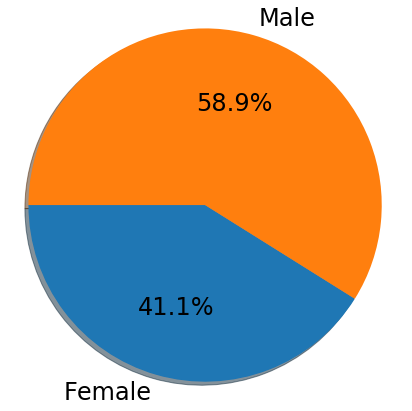

In [35]:
labels = ['Female' if i==0 else 'Male' for i in genderCounter.keys()]
value = [i for i in genderCounter.values()]

patches,texts,autotexts=plt.pie(value, labels=labels, autopct='%1.1f%%',shadow=True, startangle=180)

for i in range(len(labels)):
    texts[i].set_fontsize(24)
    autotexts[i].set_fontsize(24)
plt.axis('equal') 
fig = plt.gcf()
fig.set_size_inches(7,7)
plt.show()

In [39]:
print(names[-5:],genders[-5:])

['niveditha', 'gunvanta', 'mahanya', 'shill', 'moktarul'] [0, 0, 0, 1, 1]
